In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [2]:
# Verify Dir
import os
os.chdir('D:\\Dropbox\\Tensorflow Edureka Class\\Lending LoadData')
print(os.getcwd())

D:\Dropbox\Tensorflow Edureka Class\Lending LoadData


In [3]:
# Read dataset
loanStats = pd.read_csv('LoanStats3a.csv',skiprows = 1)
rejectStats = pd.read_csv('RejectStatsA.csv',skiprows =1)

In [4]:
print(loanStats.shape, 'Loan Data Dimension')
print(rejectStats.shape, 'Rejected Data Dimension')

(42538, 144) Loan Data Dimension
(755491, 9) Rejected Data Dimension


In [5]:
loanStats.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
rejectStats.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0


#### Preprocessing RejectedStats data

In [7]:
# Variable renaming
rejectStats.rename(columns={'Amount Requested':'loan_amnt', 'Loan Title':'title', 'Employment Length':'emp_length', 'Zip Code':'zip_code',
'State':'addr_state', 'Policy Code':'policy_code' ,'Debt-To-Income Ratio':'dti'}, inplace=True)

In [8]:
rejectStats = rejectStats[~rejectStats.title.isnull()] # Remove null from title

In [9]:
# Text processing
import string
print(string.punctuation)
print(string.digits)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
0123456789


In [10]:
rejectStats.title.replace(r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789', ' ',inplace=True)

In [11]:
# Group title to purpose
rejectStats['purpose'] = "other"
var = ['credit_card', 'car', 'small_business', 'other', 'wedding','debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy','educational']
for i in var:
    rejectStats.loc[rejectStats.title.str.contains("|".join(i.split('_')),case=False),'purpose'] = i

In [12]:
rejectStats[rejectStats.purpose.isnull()] # Check null

,loan_amnt,Application Date,title,Risk_Score,dti,zip_code,addr_state,emp_length,policy_code,purpose


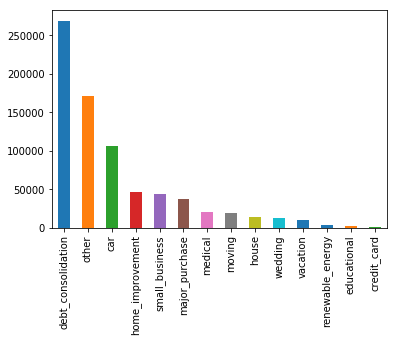

In [13]:
rejectStats.purpose.value_counts().plot(kind='bar')

In [14]:
rejectStats.dti = [x.strip('%') for x in rejectStats.dti] # remove % sign and junks
rejectStats.dti = rejectStats.dti.astype(float)
rejectStats = rejectStats[rejectStats.dti <= 100]

In [15]:
rejectStats['Application_Year'] = pd.DatetimeIndex(rejectStats['Application Date'],dtype='str').year # Extract Year
rejectStats['Target'] = 0  # Target variable

In [16]:
rejectStats_sub = rejectStats.loc[:,['loan_amnt', 'purpose', 'dti', 'addr_state', 
                                     'emp_length', 'policy_code','Target','Application_Year']]

In [17]:
print(rejectStats_sub.shape)
rejectStats_sub.head()

(734347, 8)


,loan_amnt,purpose,dti,addr_state,emp_length,policy_code,Target,Application_Year
0,1000.0,wedding,10.00,NM,4 years,0,0,2007
1,1000.0,debt_consolidation,10.00,MA,< 1 year,0,0,2007
2,11000.0,debt_consolidation,10.00,MD,1 year,0,0,2007
3,6000.0,other,38.64,MA,< 1 year,0,0,2007
4,1500.0,other,9.43,MD,< 1 year,0,0,2007


#### Preprocessing LoanStats data

In [18]:
# Drop NaN's rows from policy_code, purpose
loanStats = loanStats[~loanStats.purpose.isnull()]
loanStats = loanStats[~loanStats.policy_code.isnull()]
loanStats.reset_index(inplace=True,drop=True)
print(loanStats.shape)

(42535, 144)


In [19]:
# Data subsetting for loanstats
loanStats_sub = loanStats.loc[:,['loan_amnt', 'purpose', 'dti', 'addr_state', 'emp_length', 'policy_code']]
loanStats_sub['Target'] = 1 #Target variable

## Concat rejectedStats and loanStats dataset

In [70]:
df = pd.concat([rejectStats_sub,loanStats_sub],axis=0)

In [71]:
# Convert Data type
df['dti'] = df['dti'].astype(float)
df['policy_code'] = df['policy_code'].astype(int)

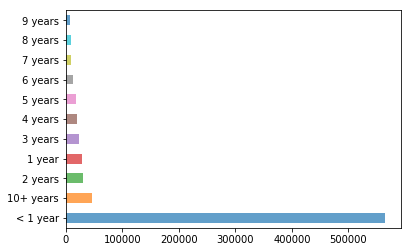

In [72]:
df['emp_length'].value_counts().plot(kind='barh',alpha=0.7)

In [73]:
# Labelencoding for ordinal, also can be used LabelEncoder()
mapping_dict = {"emp_length": 
                {"10+ years": 10,"9 years": 9,"8 years": 8,"7 years": 7,"6 years": 6,"5 years": 5,"4 years": 4,"3 years": 3,
        "2 years": 2,"1 year": 1,"< 1 year": 0,"n/a": 0 }}

In [74]:
df.emp_length.fillna('n/a',inplace=True)

In [75]:
df = df.replace(mapping_dict)

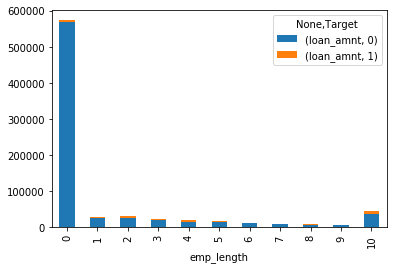

In [76]:
df[['emp_length','Target','loan_amnt']].pivot_table(index='emp_length',columns='Target',aggfunc='count').plot(kind='bar',stacked=True)

In [77]:
df.head()

,Application_Year,Target,addr_state,dti,emp_length,loan_amnt,policy_code,purpose
0,2007.0,0,NM,10.00,4,1000.0,0,wedding
1,2007.0,0,MA,10.00,0,1000.0,0,debt_consolidation
2,2007.0,0,MD,10.00,1,11000.0,0,debt_consolidation
3,2007.0,0,MA,38.64,0,6000.0,0,other
4,2007.0,0,MD,9.43,0,1500.0,0,other


In [78]:
df.corr().Target.sort_values(ascending = False) # Check correlation, exclude policy_code

policy_code         1.000000
Target              1.000000
emp_length          0.288194
loan_amnt          -0.040145
dti                -0.077102
Application_Year         NaN
Name: Target, dtype: float64

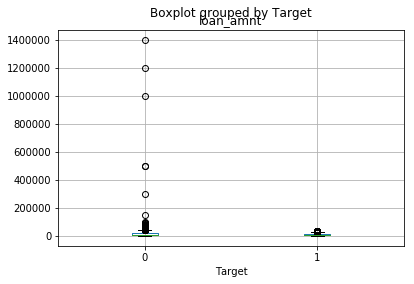

In [79]:
df.boxplot(column=['loan_amnt'],by='Target') #Check for distribution'

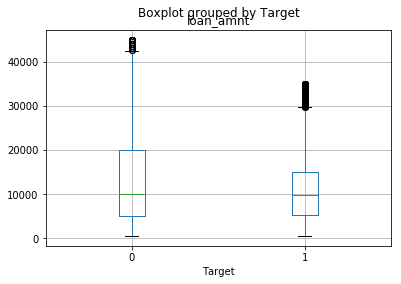

In [80]:
df[df.loan_amnt <= 45000].boxplot(column=['loan_amnt'],by='Target') #loan amounts got approved

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002952CAEAE80>,
      dtype=object)

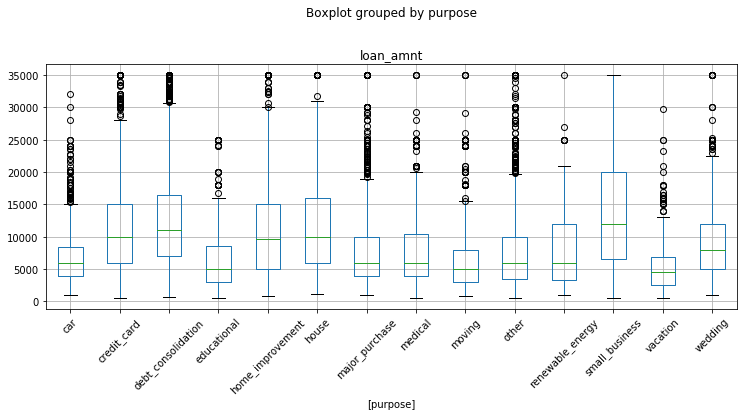

In [81]:
df[(df.loan_amnt <= 45000) & (df.Target==1) ].boxplot(column=['loan_amnt'],by=['purpose'],rot=45,figsize=(12,10),layout=(2,1)) 
# Loan amount approved for categories

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029537FCBEB8>,
      dtype=object)

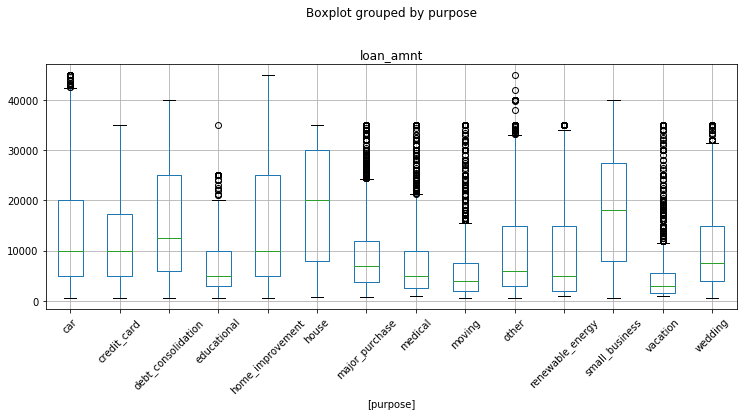

In [82]:
df[(df.loan_amnt <= 45000) & (df.Target==0) ].boxplot(column=['loan_amnt'],by=['purpose'],rot=45,figsize=(12,10),layout=(2,1)) 
# Loan amount declined for categories

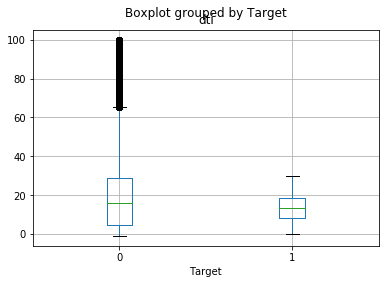

In [83]:
df.boxplot(column=['dti'],by='Target') # dti distribution of actual data

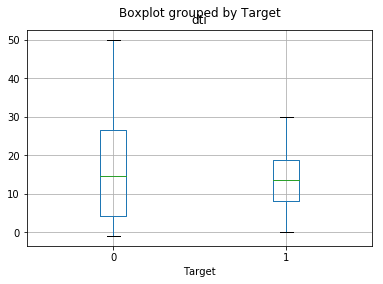

In [84]:
df[df.dti <= 50].boxplot(column=['dti'],by='Target') # from distributions when having more dti request get rejected

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000295437C3940>,
      dtype=object)

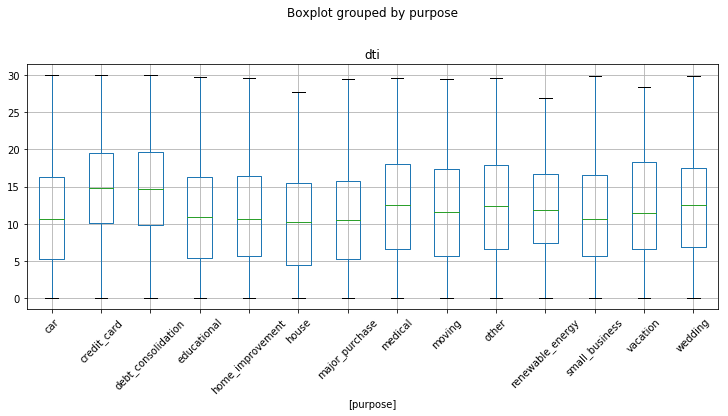

In [85]:
df[(df.dti <= 50) & (df.Target==1) ].boxplot(column=['dti'],by=['purpose'],rot=45,figsize=(12,10),layout=(2,1)) 
# dti ratio for approved categories

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000295471A2748>,
      dtype=object)

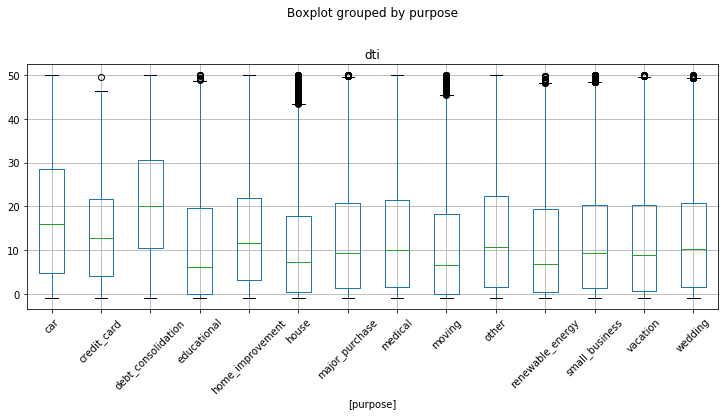

In [86]:
df[(df.dti <= 50) & (df.Target==0) ].boxplot(column=['dti'],by=['purpose'],rot=45,figsize=(12,10),layout=(2,1)) 
## dti ratio for declined categories

### Spliting data, Create dummies variables

In [101]:
df_bakup = df.copy()
df_bakup.shape

(776882, 8)

In [102]:
print(new_df.shape)
new_df.head()

(173793, 8)


,Application_Year,Target,addr_state,dti,emp_length,loan_amnt,policy_code,purpose
388882,2011.0,0,CA,27.56,0,1200.0,0,vacation
301482,2011.0,0,MN,5.43,0,8000.0,0,other
708954,2012.0,0,FL,4.83,0,10000.0,0,debt_consolidation
664260,2012.0,0,AL,33.83,0,1000.0,0,moving
103694,2010.0,0,WI,31.17,3,15000.0,0,educational


In [103]:
df = new_df # Comment the line when run for the first time, As new_df is sampled data to create, below is the code

In [104]:
df = pd.concat([df,pd.get_dummies(df['purpose'])],axis=1)

In [105]:
# Subset model test data 2008 Q1 to Q4
df_train = df[df.Application_Year!=2008]
df_valid = df[df.Application_Year==2008] # For final validation
print(df.shape, 'Full dataset shape')
print(df_valid.shape, 'Final Validation dataset shape')
print(df_train.shape,'Train dataset shape')

(173793, 22) Full dataset shape
(24675, 22) Final Validation dataset shape
(149118, 22) Train dataset shape


In [106]:
df_train.Target.value_counts(normalize = True) # Target ratio # Data is already imblance will take approach later to deal with

0    0.714756
1    0.285244
Name: Target, dtype: float64

### Build Classification model

In [107]:
X = df_train.drop(['Application_Year','Target','purpose','addr_state','policy_code'],axis=1)
y = df_train['Target']

In [108]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)

In [109]:
# Model
lr = LogisticRegression()
model = lr.fit(X_train,y_train)

In [110]:
prediction = model.predict(X_test) # Predcition

In [111]:
accuracy_score(y_train,model.predict(X_train)) # Train Accuracy

0.790048944539531

In [112]:
accuracy_score(y_test,prediction) # Test Accuracy

0.7925176288890243

In [113]:
print(confusion_matrix(y_test,prediction))

[[31996  3179]
 [ 7031  7003]]


In [114]:
 print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     35175
           1       0.69      0.50      0.58     14034

   micro avg       0.79      0.79      0.79     49209
   macro avg       0.75      0.70      0.72     49209
weighted avg       0.78      0.79      0.78     49209



* Precision : What proportion of positive identifications was actually correct?
* Recall : What proportion of actual positives was identified correctly?

### Cross validation

In [115]:
from sklearn.model_selection import cross_val_score

In [116]:
scores = cross_val_score(model, X, y, cv=10)

In [117]:
print(scores)

[0.79527929 0.79802857 0.79802857 0.7965397  0.78809013 0.78720408
 0.79518476 0.78237543 0.77419355 0.78928308]


In [118]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.01)


###### Validation on the Unseen data

In [119]:
X_val = df_valid.drop(['Application_Year','Target','purpose','addr_state','policy_code'],axis=1)
y_val = df_valid['Target']

In [120]:
y_pred_val = model.predict(X_val)

In [121]:
accuracy_score(y_val,y_pred_val) # Accuracy on unseen data

0.6663019250253293

### Sampling to handle imblance

In [87]:
df.shape

(776882, 8)

In [88]:
df.Target.value_counts(normalize=True)

0    0.945249
1    0.054751
Name: Target, dtype: float64

In [89]:
print(rejectStats_sub[(rejectStats_sub.loan_amnt >= 45000) & (rejectStats.Application_Year !=2008)].shape)
print(df[(df.loan_amnt>=45000) & (df.Target == 0) & (df.Application_Year !=2008)].shape)
# Both the output rows should matches

(155, 8)
(155, 8)


In [90]:
print(rejectStats_sub[~(rejectStats_sub.loan_amnt >= 45000)& (rejectStats.Application_Year !=2008)].shape)
print(df[~(df.loan_amnt>=45000) & (df.Target == 0) & (df.Application_Year !=2008)].shape)
# Both the output rows should matches

(709517, 8)
(709517, 8)


In [96]:
# Also randomly select 60k Observation
from sklearn.utils import shuffle
new_df = shuffle(df[~(df.loan_amnt>=45000) & (df.Target == 0) & (df.Application_Year !=2008)])
new_df = new_df.sample(frac=.15)
new_df.shape # ~10% of actual data dim (60425, 9)

(106428, 8)

In [97]:
new_df = pd.concat([new_df, df[(df.loan_amnt>=45000) & (df.Target == 0) & (df.Application_Year !=2008)]],axis=0) 
# NOW WE HAVE COLLECTED THE RANDOM SAMPLE, WILL CREATE NEW DF

In [98]:
new_df.shape # data shape should be ~10% of actual data 

(106583, 8)

In [99]:
# Now we subset the samples form declined, will add approved one
new_df = pd.concat([new_df, df[df.Target==1]],axis=0)
new_df.shape # final df

(149118, 8)

In [100]:
# Lets go back Split data and try model output, before subset 2008 for validation
new_df =  pd.concat([new_df, df[df.Application_Year ==2008]],axis=0)
new_df.shape

(173793, 8)

## Notes:

### Before Sampling
* Target class ration was 
* Declined 0    0.945249 
* Approved 1    0.054751

* Data Dimension: (776882, 22)
* Accuarcy on test dataset: 0.9432902682603563
* Accuracy of CV=10 Scores: [0.92765414 0.94053601 0.94561359 0.94823254 0.94482924 0.94505451 0.94641053 0.94738102 0.94606488 0.94444297]
* Accuracy on 2008 Q1 to Q4 Unseen Data: 0.9820060790273556

* As data is imbalance and we can used random sampling(Methods) or ensemble Techniques, Here am trying random sampling

### After sampling
* Target class ration was 
* Declined 0    0.764854 
* Approved 1    0.235146

* Data Dimension: (180888, 36)
* Accuarcy on test dataset: 0.8021376888906132
* Accuracy of CV=10 Scores: [0.8098835  0.81314812 0.80559467 0.81263603 0.80284215 0.80084502 0.82542731 0.80334166 0.78265045 0.78169014]
* Accuracy on 2008 Q1 to Q4 Unseen Data: 0.7414387031408308

* We iterate with sampling or algorithms to improve the model accuracies and predicting power

## END

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
rf = RandomForestClassifier(random_state=101)

In [125]:
rf_model = rf.fit(X_train,y_train)

In [126]:
rf_prediction = rf_model.predict(X_test)

In [127]:
accuracy_score(y_train,rf_model.predict(X_train)) # Train accuracy

0.9831246434255172

In [128]:
accuracy_score(y_test,rf_prediction) # Test Accuracy

0.8650653335771912

In [129]:
accuracy_score(y_val,rf_model.predict(X_val)) # val Accuracy

0.7890577507598784

In [130]:
print(classification_report(y_val, rf_model.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88     24675
           1       0.00      0.00      0.00         0

   micro avg       0.79      0.79      0.79     24675
   macro avg       0.50      0.39      0.44     24675
weighted avg       1.00      0.79      0.88     24675



In [131]:
print(confusion_matrix(y_val, rf_model.predict(X_val)))

[[19470  5205]
 [    0     0]]


* Randomforest model need to be tune hyperparameter,It's iterative task so not trying now